In [4]:
import os
import warnings
import time
import sys
import pickle
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from skopt  import BayesSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

from sklearn.metrics import precision_score, accuracy_score

In [19]:
from importlib import reload
import binary_output, run_models, process_df, multiclass_output, output
from binary_output import calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics
from run_models import get_classification_cv_predictions, get_df_work_columns
from process_df import split_df
from multiclass_output import print_conf_matrix, get_avg_cm, get_avg_cm_df, get_cv_avg_one_away_accuracy, get_cv_avg_one_away_accuracy_per_class, get_multiclass_metrics, get_cv_multiclass_metrics
from output import print_formatted, print_output, print_formatted_params
reload(binary_output)
reload(run_models)
reload(process_df)
reload(output)
reload(multiclass_output)
from binary_output import calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics
from run_models import get_classification_cv_predictions, get_df_work_columns
from process_df import split_df
from multiclass_output import print_conf_matrix, get_avg_cm, get_avg_cm_df, get_cv_avg_one_away_accuracy, get_cv_avg_one_away_accuracy_per_class, get_multiclass_metrics, get_cv_multiclass_metrics
from output import print_formatted, print_output, print_formatted_params

In [6]:
# sorted_revenue = sorted(list(df_full['META__revenue']))
# for i in range(1, 9):
#     print(sorted_revenue[min(i*775, df_full.shape[0]-1)])

<BarContainer object of 9 artists>

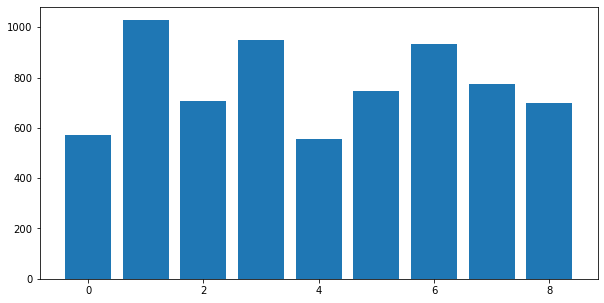

In [4]:
def get_profit_class(revenue):
    if revenue <= 1000000:
        return 0
    if revenue <= 5000000:
        return 1
    if revenue <= 10000000:
        return 2
    if revenue <= 20000000:
        return 3
    if revenue <= 30000000:
        return 4
    if revenue <= 50000000:
        return 5
    if revenue <= 100000000:
        return 6
    if revenue <= 200000000:
        return 7
    return 8

df_full = pd.read_csv('outliers/df_full_dropped_6965.csv', index_col='id')
revenue_9 = list(df_full['META__revenue'].apply(get_profit_class))
counts = []
for i in range(9):
    counts.append(revenue_9.count(i))

from matplotlib.pyplot import bar
bar(range(9), height=counts)

In [7]:
# df_full = pd.read_csv('outliers/final/df.csv', index_col='id')

# def set_profit(dataset):
#     df = df_full.loc[dataset.index]
#     return df.META__revenue.apply(get_profit_class)

# with open(f'outliers/final/nan_filled_data.pickle', 'rb') as handle:
#    data = pickle.load(handle)
# y_train, y_val, y_test = data['y_train'], data['y_val'], data['y_test']

# y_train, y_val, y_test = set_profit(y_train), set_profit(y_val), set_profit(y_test)
# X_train, X_val, X_test = data['X_train'], data['X_val'], data['X_test']

# X = pd.concat([X_train, X_test, X_val])
# y = np.concatenate([y_train, y_test, y_val])

# data_binary = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
# with open(f'classification/multi_data_dropped_nan_filled.pickle', 'wb') as handle:
#    pickle.dump(data_binary, handle)

In [8]:
with open(f'classification/multi_data_dropped_nan_filled.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
X = pd.concat([X_train, X_test, X_val])
y = np.concatenate([y_train, y_test, y_val])

In [16]:
def create_lgb(model_params={}):
    def_params = {
        'bagging_fraction': 0.9320921709538026,
        'feature_fraction': 0.9108988200799922,
        'learning_rate': 0.036716125518746354,
        'max_bin': 153,
        'max_depth': 79,
        'min_data_in_leaf': 70,
        'min_sum_hessian_in_leaf': 25.77863726071913,
        'n_estimators': 8099,
        'num_leaves': 88,
        'subsample': 0.34664932012113514,
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 9,
        'class_weight': 'balanced',
        'boost_from_average': False,
    }
    return lgb.LGBMClassifier(**model_params) if model_params else lgb.LGBMClassifier(**def_params)

def fit_lgb(model, X, y, X_val=None, y_val=None, eval_metric='multi_logloss', patience=30, **kwargs):
    # def evalerror(y_true, y_pred):
    #     y_pred = y_pred.reshape(len(np.unique(y_true)), -1).T
    #     y_pred = y_pred.reshape(len(np.unique(y_true)), -1).T.argmax(axis = 1)
    #     return 'log_loss', metrics.log_loss(y_true, y_pred), False
    #     return 'matthews_corrcoef', metrics.matthews_corrcoef(y_true, y_pred), True
    #     return 'balanced_accuracy_score', metrics.balanced_accuracy_score(y_true, y_pred), True
    #     return 'f1_score', metrics.f1_score(y_true, y_pred,  average = 'weighted'), True
    start = time.time()
    eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
    fit_params = {'early_stopping_rounds': patience} if eval_set else {}
    model = model.fit(X.values, y, verbose=-1, eval_metric=eval_metric, eval_set=eval_set, **fit_params)
    # model = model.fit(X.values, y, verbose=-1, eval_metric=evalerror, eval_set=eval_set, **fit_params)
    print(f'model fit time: {time.time() - start}')
    return model

def create_and_fit_lgb(X, y, X_val=None, y_val=None, eval_metric='multi_logloss', patience=1, model_params={}, verbose=-1, **kwargs):
    return fit_lgb(create_lgb(model_params=model_params), X, y, X_val, y_val, eval_metric, patience=patience)

# def create_and_fit_lgb_pipe(X, y, X_val=None, y_val=None, eval_metric='multi_logloss', patience=30, model_params={}, verbose=-1):
#     pipe = Pipeline([
#             ('powertransform', PowerTransformer()),
#             ('model', create_lgb()),
#         ])

#     fit_params = {'model__verbose': -1}
#     eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
#     if eval_set:
#         fit_params['model__early_stopping_rounds'] = patience
#         fit_params['model__eval_metric'] = eval_metric
#         fit_params['model__eval_set'] = eval_set
#     pipe = pipe.fit(X.values, y, **fit_params)
#     return pipe

In [10]:
# %%time
# params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'class_weight': 'balanced', 'num_class': 9, 'verbose': -100, 'random_state': 0, 'reg_lambda': 17.94605853662356, 'min_sum_hessian_in_leaf': 1.0450248159691256, 'boost_from_average': False, 'num_leaves': 24, 'max_depth': 83, 'max_bin': 148, 'n_estimators': 7358, 'min_child_samples': 32, 'min_data_in_leaf': 40, 'bagging_freq': 63, 'learning_rate': 0.01975537320162571, 'min_child_weight': 0.10282514437131501, 'subsample': 0.8746700426045616, 'colsample_bytree': 0.9700861060202407, 'reg_alpha': 0.40410914811614684, 'bagging_fraction': 0.8058214665779686, 'feature_fraction': 0.6599514195814}

# p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_lgb, X, y, n_splits=10, patience=10, model_params=params)
# cv_result = get_cv_multiclass_metrics(p_class, p_proba)
# print('\n\n *********************************')
# print_output(cv_result)
# print('*********************************\n\n')

#  *********************************
# one_away_accuracy: 0.8053185656095913
# balanced_accuracy_score: 0.42482687877459463
# cohen_kappa_score: 0.35391101440095296
# matthews_corrcoef: 0.3541946365821193
# zero_one_loss: 0.5715781097973252
# f1_score: 0.4249865539364151
# precision_score: 0.4240014557155563
# recall_score: 0.42842189020267485
# roc_auc_score: 0.8617218622930123
# *********************************


# CPU times: user 21min 24s, sys: 3.88 s, total: 21min 28s
# Wall time: 2min 54s

In [11]:
# %%time
# params = {'n_estimators': 1000, 'objective': 'multiclass', 'metric': 'multi_logloss', 'class_weight': 'balanced', 'num_class': 9, 'verbose': -1, 'random_state': 0, 'reg_lambda': 17.94605853662356, 'min_sum_hessian_in_leaf': 1.0450248159691256, 'boost_from_average': True, 'num_leaves': 24, 'max_depth': 83, 'max_bin': 148, 'min_child_samples': 32, 'min_data_in_leaf': 40, 'bagging_freq': 63, 'learning_rate': 0.01975537320162571, 'min_child_weight': 0.10282514437131501, 'subsample': 0.8746700426045616, 'colsample_bytree': 0.9700861060202407, 'reg_alpha': 0.40410914811614684, 'bagging_fraction': 0.8058214665779686, 'feature_fraction': 0.6599514195814}

# cv_result = lgb.cv(params, train_data, nfold=10, seed=0, stratified=True, shuffle=True, early_stopping_rounds=10, return_cvbooster=True, num_boost_round=8000)

# list_of_importances = sorted(list(zip(list(X.columns), cv_result['cvbooster'].feature_importance()[0])), key=lambda t:t[1])
# unique_importances = np.unique(np.array([t[1] for t in list_of_importances]))

# params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'class_weight': 'balanced', 'num_class': 9, 'verbose': -1, 'random_state': 0, 'reg_lambda': 17.94605853662356, 'min_sum_hessian_in_leaf': 1.0450248159691256, 'boost_from_average': True, 'num_leaves': 24, 'max_depth': 83, 'max_bin': 148, 'min_child_samples': 32, 'min_data_in_leaf': 40, 'bagging_freq': 63, 'learning_rate': 0.01975537320162571, 'min_child_weight': 0.10282514437131501, 'subsample': 0.8746700426045616, 'colsample_bytree': 0.9700861060202407, 'reg_alpha': 0.40410914811614684, 'bagging_fraction': 0.8058214665779686, 'feature_fraction': 0.6599514195814, 'n_estimators': 100}

# res_by_features = []
# for drop_f_importance in range(1, 20):
#     importance = unique_importances[drop_f_importance]
#     not_val_featurs = [t[0] for t in list_of_importances if t[1] < importance]
#     Xx = X.drop(not_val_featurs, axis=1)

#     p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_lgb, Xx, y, n_splits=10, patience=10, model_params=params)
#     cvr = get_cv_multiclass_metrics(p_class, p_proba)
#     print('\n\n *********************************')
#     print_output(cvr)
#     print('*********************************\n\n')
#     res_by_features.append({'drop_features': not_val_featurs, 'cv_result': cvr})

/home/stas/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


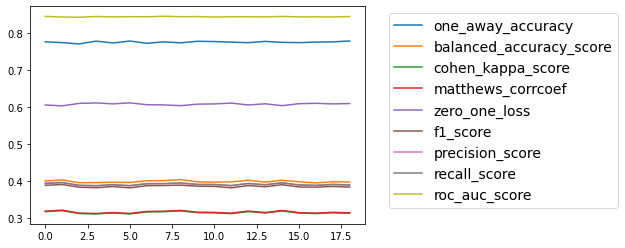

In [205]:
metrics_list = list(res_by_features[0]['cv_result'].keys()) 
for metric in metrics_list:
    plt.plot([res_by_features[i]['cv_result'][metric] for i in range(len(res_by_features))])
plt.legend(metrics_list, loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 14})
plt.show()

In [12]:
# refit_boosters = cv_result['cvbooster'].refit(X_train, y_train)
# ypred = [refit_boosters[n].predict(X_test) for n in range(len(refit_boosters))]
# pproba = ([(np.array(y_test), pp) for pp in ypred])
# pclass = ([(np.array(y_test), [pp[i].argmax() for i in range(len(pp))]) for pp in ypred])
# print_output(get_cv_multiclass_metrics(pclass, pproba))

# # one_away_accuracy: 0.9695402298850573
# # balanced_accuracy_score: 0.9192843956805075
# # cohen_kappa_score: 0.9115937717242453
# # matthews_corrcoef: 0.9118529376273841
# # zero_one_loss: 0.07801724137931032
# # f1_score: 0.9218353392458384
# # precision_score: 0.9237562972852679
# # recall_score: 0.9219827586206896
# # roc_auc_score: 0.9916240962624984

In [13]:
def convert_lgb_classifier_parameters(params):
    get_float = lambda val: max(min(val, 1), 0)
    get_int = lambda val: int(round(val))

    return_params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'class_weight': 'balanced',
        'boost_from_average': True,
        'num_class': 9,
        'verbose': -1,
        'random_state': 0,
        'reg_lambda': params['reg_lambda'],
        'min_sum_hessian_in_leaf': params['min_sum_hessian_in_leaf'],
    }

    int_params = ['num_leaves', 'max_depth', 'max_bin', 'min_child_samples', 'min_data_in_leaf', 'bagging_freq']
    float_params = ['learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_alpha', 'bagging_fraction', 'feature_fraction']
    for param in int_params:
        if param in params:
            return_params[param] = get_int(params[param])
    for param in float_params:
        if param in params:
            return_params[param] = get_float(params[param])
    return return_params

In [14]:
# Fine tune lgb binary classifier with hyperas
from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

def get_data():
    with open(f'classification/multi_data_dropped_nan_filled.pickle', 'rb') as handle:
        data = pickle.load(handle)

    X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
    X = pd.concat([X_train, X_test, X_val])
    y = np.concatenate([y_train, y_test, y_val])
    return X, y

def get_lgb_hyperas_model(X, y):
    reg_lambda={{uniform(10, 100)}}
    min_sum_hessian_in_leaf={{uniform(0, 100)}}
    num_leaves={{uniform(5, 150)}}
    max_depth={{uniform(10, 100)}}
    max_bin={{uniform(20, 200)}}
    # min_child_samples={{uniform(1, 150)}}
    min_data_in_leaf={{uniform(1, 80)}}
    learning_rate={{uniform(0.01, 0.0101)}}
    # min_child_weight={{uniform(0.1, 0.5)}}
    # subsample={{uniform(0.1, 1.0)}}
    # colsample_bytree={{uniform(0.01, 1)}}
    reg_alpha={{uniform(0, 1)}}
    bagging_fraction={{uniform(0.5, 1)}}
    bagging_freq={{uniform(0, 100)}}
    feature_fraction={{uniform(0.6, 1.0)}}

    params_raw = {
        'reg_lambda': reg_lambda,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'max_bin':max_bin,
        # 'min_child_samples': min_child_samples,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        # 'min_child_weight': min_child_weight,
        # 'subsample': subsample,
        # 'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
    }
    params = convert_lgb_classifier_parameters(params_raw)
    print(params)
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    start = time.time()
    cv_result = lgb.cv(params, train_data, nfold=10, seed=0, stratified=True, shuffle=True, early_stopping_rounds=10, num_boost_round=100)
    _loss = min(cv_result['multi_logloss-mean'])
    print(f'loss: {_loss}')
    print(f'CV time: {time.time() - start}\n\n')
    return {'loss': _loss, 'status': STATUS_OK}

In [15]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=get_lgb_hyperas_model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='classification_lgm_multi',
                                      eval_space=True,
                                      return_space=True,
                                      functions=[convert_lgb_classifier_parameters, create_and_fit_lgb, fit_lgb, create_lgb, 
                                        get_cv_multiclass_metrics, get_multiclass_metrics, get_one_away_accuracy, print_output])

9704, 'bagging_fraction': 0.7767563179130962, 'feature_fraction': 0.9969234507412423}
loss: 1.7156988058538842
CV time: 24.511351823806763


{'objective': 'multiclass', 'metric': 'multi_logloss', 'class_weight': 'balanced', 'boost_from_average': True, 'num_class': 9, 'verbose': -1, 'random_state': 0, 'reg_lambda': 11.768889070978869, 'min_sum_hessian_in_leaf': 79.38547938058565, 'num_leaves': 103, 'max_depth': 56, 'max_bin': 168, 'min_child_samples': 94, 'min_data_in_leaf': 28, 'bagging_freq': 15, 'learning_rate': 0.010017674903914767, 'min_child_weight': 0.1286114761830644, 'subsample': 0.21445756991796133, 'colsample_bytree': 0.8058229407271417, 'reg_alpha': 0.9541668901580358, 'bagging_fraction': 0.9469825451693352, 'feature_fraction': 0.9317500483868927}
loss: 1.721072520799393
CV time: 19.65987539291382


{'objective': 'multiclass', 'metric': 'multi_logloss', 'class_weight': 'balanced', 'boost_from_average': True, 'num_class': 9, 'verbose': -1, 'random_state': 0, 'reg_lambda': 25.

In [20]:
# params = convert_lgb_classifier_parameters(best_run)
# best_run
convert_lgb_classifier_parameters(best_run)

{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'class_weight': 'balanced',
 'boost_from_average': True,
 'num_class': 9,
 'verbose': -1,
 'random_state': 0,
 'reg_lambda': 10.089168169584678,
 'min_sum_hessian_in_leaf': 3.5850119191958356,
 'num_leaves': 143,
 'max_bin': 21,
 'min_child_samples': 79,
 'min_data_in_leaf': 36,
 'learning_rate': 0.010065966462468427,
 'min_child_weight': 0.1287596042350692,
 'subsample': 0.41948519851532,
 'colsample_bytree': 0.8655823454895997,
 'reg_alpha': 0.04194745138602063,
 'bagging_fraction': 0.6642718549326513,
 'feature_fraction': 0.9564091988511934}

In [17]:
%%time
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'class_weight': 'balanced',
    'boost_from_average': True,
    'num_class': 9,
    'verbose': -1,
    'random_state': 0,
    'reg_lambda': 10.089168169584678,
    'min_sum_hessian_in_leaf': 3.5850119191958356,
    'num_leaves': 143,
    'max_bin': 21,
    'min_child_samples': 79,
    'min_data_in_leaf': 36,
    'learning_rate': 0.010065966462468427,
    'min_child_weight': 0.1287596042350692,
    'subsample': 0.41948519851532,
    'colsample_bytree': 0.8655823454895997,
    'reg_alpha': 0.04194745138602063,
    'bagging_fraction': 0.6642718549326513,
    'feature_fraction': 0.9564091988511934,
    'n_estimators': 8000,
}

p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_lgb, X, y, n_splits=10, patience=10, model_params=params)

#  *********************************
# one_away_accuracy: 0.8053185656095913
# balanced_accuracy_score: 0.42482687877459463
# cohen_kappa_score: 0.35391101440095296
# matthews_corrcoef: 0.3541946365821193
# zero_one_loss: 0.5715781097973252
# f1_score: 0.4249865539364151
# precision_score: 0.4240014557155563
# recall_score: 0.42842189020267485
# roc_auc_score: 0.8617218622930123
# *********************************


# CPU times: user 21min 24s, sys: 3.88 s, total: 21min 28s
# Wall time: 2min 54s

split num: 1
[LightGBM] [Warning] bagging_fraction is set=0.6642718549326513, subsample=0.41948519851532 will be ignored. Current value: bagging_fraction=0.6642718549326513
[LightGBM] [Warning] feature_fraction is set=0.9564091988511934, colsample_bytree=0.8655823454895997 will be ignored. Current value: feature_fraction=0.9564091988511934
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.5850119191958356, min_child_weight=0.1287596042350692 will be ignored. Current value: min_sum_hessian_in_leaf=3.5850119191958356
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=36
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[554]	valid_0's multi_logloss: 1.42332
model fit time: 24.520905017852783
split num: 2
[LightGBM] [Warning] bagging_fraction is set=0.6642718549326513, subsample=0.41948519851532 will be ignored. Current value: bagging_fraction=0.6642718549326513
[LightGBM]

NameError: name 'get_cv_multiclass_metrics' is not defined

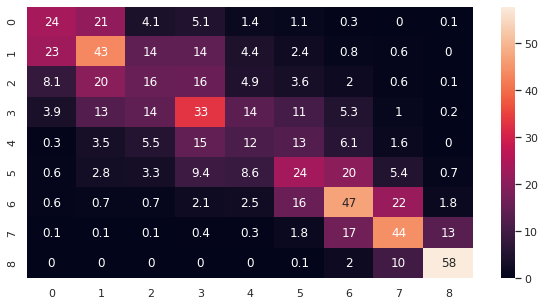

one_away_accuracy: 0.7989
balanced_accuracy_score: 0.426
cohen_kappa_score: 0.3561
matthews_corrcoef: 0.3565
zero_one_loss: 0.569
f1_score: 0.4255
precision_score: 0.4236
recall_score: 0.431
log_loss: 1.399
roc_auc_score: 0.8594


In [20]:
cv_result = get_cv_multiclass_metrics(p_class, p_proba)
print_conf_matrix(get_avg_cm_df(p_class))
print_output(cv_result)

In [42]:
# Fine tune lgb binary classifier with bayesian optimization
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=30, n_folds=5, random_seed=0, output_process=False):
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    def model_eval(**params_raw):
        params, dataset = convert_lgb_classifier_parameters(params_raw), lgb.Dataset(data=X, label=y, free_raw_data=False)
        start = time.time()
        cv_result = lgb.cv(params, dataset, nfold=10, seed=0, stratified=True, shuffle=True, early_stopping_rounds=10, num_boost_round=100)
        print(f'CV time: {time.time() - start}\n\n')
        return -min(cv_result['multi_logloss-mean'])

    pbounds = {
        'reg_lambda': (0, 20),
        'min_sum_hessian_in_leaf': (0, 10),
        'num_leaves': (100, 200),
        'max_bin':(1,50),
        # 'min_child_samples': (50, 100),
        'min_data_in_leaf': (10, 50),
        'learning_rate': (0.005, 0.02),
        # 'min_child_weight': (0.05, 0.2),
        # 'subsample': (0.3, 0.6),
        # 'colsample_bytree': (0.75, 1.0),
        'reg_alpha': (0, 0.1),
        'bagging_fraction': (0.4, 1.0),
        'feature_fraction': (0.8, 1.0),
    }

    bounds_transformer = SequentialDomainReductionTransformer()
    optimizer = BayesianOptimization(model_eval, pbounds, random_state=0, bounds_transformer=bounds_transformer)
    optimizer.maximize(init_points=init_round, n_iter=opt_round)
    model_params=[optimizer.res[model]['target'] for model in range(len(optimizer.res))]
    return {
        'target': optimizer.res[pd.Series(model_params).idxmax()]['target'], 
        'params': optimizer.res[pd.Series(model_params).idxmax()]['params'],
        'bounds_transformer': bounds_transformer,
        'optimizer': optimizer,
    }

In [43]:
%%time
lgb_optimized = bayes_parameter_opt_lgb(X, y, init_round=2, opt_round=50, n_folds=10, random_seed=0)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | min_da... | min_su... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
CV time: 30.69855761528015


|  1        | -1.601    |  0.7293   |  0.943    |  0.01404  |  27.7     |  26.95    |  6.459    |  143.8    |  0.08918  |  19.27    |
CV time: 38.76791572570801


|  2        | -1.61     |  0.6301   |  0.9583   |  0.01293  |  28.83    |  47.02    |  0.7104   |  108.7    |  0.002022 |  16.65    |
CV time: 62.97829461097717


|  3        | -1.678    |  0.6854   |  0.8872   |  0.009817 |  28.47    |  27.65    |  6.648    |  141.9    |  0.0615   |  17.92    |
CV time: 62.884987115859985


|  4        | -1.59     |  0.6372   |  0.9826   |  0.01448  |  17.61    |  15.8     |  8.659    |  166.4    |  0.06044  |  17.28    |
CV time: 56.87473964691162


|  5        | -1.608    |  0.6322   |  0.9731   | 

In [59]:
%%time
params = convert_lgb_classifier_parameters(lgb_optimized['params'])
params['n_estimators'] = 8000
print_output(params)


p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_lgb, X, y, n_splits=10, patience=30, model_params=params)
cv_result = get_cv_multiclass_metrics(p_class, p_proba)
print('\n\n *********************************')
print_output(cv_result)
print('*********************************\n\n')

#  *********************************
# one_away_accuracy: 0.8053185656095913
# balanced_accuracy_score: 0.42482687877459463
# cohen_kappa_score: 0.35391101440095296
# matthews_corrcoef: 0.3541946365821193
# zero_one_loss: 0.5715781097973252
# f1_score: 0.4249865539364151
# precision_score: 0.4240014557155563
# recall_score: 0.42842189020267485
# roc_auc_score: 0.8617218622930123
# *********************************


# CPU times: user 21min 24s, sys: 3.88 s, total: 21min 28s
# Wall time: 2min 54s

objective: multiclass
metric: multi_logloss
class_weight: balanced
boost_from_average: True
num_class: 9
verbose: -1
random_state: 0
reg_lambda: 11.2602
min_sum_hessian_in_leaf: 9.9653
num_leaves: 178
max_bin: 36
min_data_in_leaf: 13
learning_rate: 0.02
reg_alpha: 0.0647
bagging_fraction: 0.9342
feature_fraction: 0.97
n_estimators: 8000
split num: 1
[LightGBM] [Warning] bagging_fraction is set=0.9341934961540067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341934961540067
[LightGBM] [Warning] feature_fraction is set=0.9700200838110312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9700200838110312
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.965283741341308, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9.965283741341308
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
Training until validation scores don't improve for 30 rou

In [46]:
%%time
params = convert_lgb_classifier_parameters(lgb_optimized['params'])
params['n_estimators'] = 8000
print_output(params)


p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_lgb, X, y, n_splits=10, patience=10, model_params=params)
cv_result = get_cv_multiclass_metrics(p_class, p_proba)
print('\n\n *********************************')
print_output(cv_result)
print('*********************************\n\n')

#  *********************************
# one_away_accuracy: 0.8053185656095913
# balanced_accuracy_score: 0.42482687877459463
# cohen_kappa_score: 0.35391101440095296
# matthews_corrcoef: 0.3541946365821193
# zero_one_loss: 0.5715781097973252
# f1_score: 0.4249865539364151
# precision_score: 0.4240014557155563
# recall_score: 0.42842189020267485
# roc_auc_score: 0.8617218622930123
# *********************************


# CPU times: user 21min 24s, sys: 3.88 s, total: 21min 28s
# Wall time: 2min 54s

objective: multiclass
metric: multi_logloss
class_weight: balanced
boost_from_average: True
num_class: 9
verbose: -1
random_state: 0
reg_lambda: 11.260193111365984
min_sum_hessian_in_leaf: 9.965283741341308
num_leaves: 178
max_bin: 36
min_data_in_leaf: 13
learning_rate: 0.019972991188800797
reg_alpha: 0.06472518963838858
bagging_fraction: 0.9341934961540067
feature_fraction: 0.9700200838110312
n_estimators: 8000
split num: 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[448]	valid_0's multi_logloss: 1.37176
model fit time: 14.664367914199829
split num: 2
[LightGBM] [Warning] bagging_fraction is set=0.9341934961540067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341934961540067
[LightGBM] [Warning] feature_fraction is set=0.9700200838110312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9700200838110312
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.965283741341308, min_child_weight

In [53]:
print_output(get_cv_multiclass_metrics(p_class, p_proba))

one_away_accuracy: 0.8019
balanced_accuracy_score: 0.427
cohen_kappa_score: 0.3554
matthews_corrcoef: 0.3558
zero_one_loss: 0.57
f1_score: 0.4256
precision_score: 0.4242
recall_score: 0.43
roc_auc_score: 0.8602


In [58]:
print_output(params)

objective: multiclass
metric: multi_logloss
class_weight: balanced
boost_from_average: True
num_class: 9
verbose: -1
random_state: 0
reg_lambda: 11.2602
min_sum_hessian_in_leaf: 9.9653
num_leaves: 178
max_bin: 36
min_data_in_leaf: 13
learning_rate: 0.02
reg_alpha: 0.0647
bagging_fraction: 0.9342
feature_fraction: 0.97
n_estimators: 8000


In [25]:
get_one_away_accuracy_per_class(p_class[3][0], p_class[3][1])

{0: 0.7543859649122807,
 1: 0.7864077669902912,
 2: 0.7571428571428571,
 3: 0.6421052631578947,
 4: 0.6785714285714286,
 5: 0.6666666666666666,
 6: 0.8924731182795699,
 7: 0.9487179487179487,
 8: 0.9714285714285714}

In [26]:
metrics.multilabel_confusion_matrix(p_class[0][0], p_class[0][1])

array([[[614,  26],
        [ 31,  26]],

       [[526,  69],
        [ 56,  46]],

       [[577,  49],
        [ 60,  11]],

       [[536,  66],
        [ 63,  32]],

       [[595,  46],
        [ 49,   7]],

       [[583,  39],
        [ 59,  16]],

       [[550,  53],
        [ 38,  56]],

       [[589,  31],
        [ 31,  46]],

       [[609,  18],
        [ 10,  60]]])

In [28]:
def get_one_vs_all(p):
    return [{label: (p[fold][0] == label, p[fold][1] == label) for label in range(9)} for fold in range(len(p))]

one_vs_all_preds = get_one_vs_all(p_class)

/home/stas/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


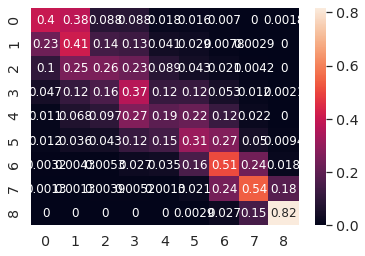

In [61]:
print_conf_matrix(get_avg_cm(p_class))

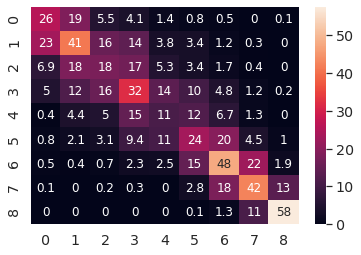

In [47]:
print_conf_matrix(get_avg_cm(p_class))

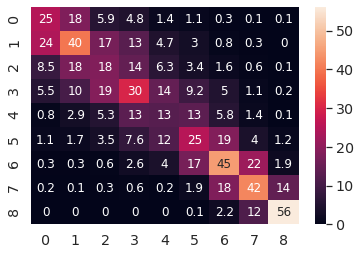

In [385]:
print_conf_matrix(get_avg_cm(p_class))